# Venture capital returns
Dataset: 3,897 funds inception years ranging from the 1969 to 2023, their various performance metrics, and key information

Sources: 
- Private Capital Performance from Preqin
- Fama-French five-factor dataset from Kenneth French's data library
- Aswath Damodaran's dataset that includes the historical returns for equities, bonds, and T-bills from 1928 to 2022


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

## Data Preparation

In [3]:
# Create a dataframe from the excel file
vc_returns = pd.read_excel('data/preqin_venture_performance.xlsx')
vc_returns.head()

,FUND ID,FIRM ID,NAME,ASSET CLASS,VINTAGE / INCEPTION YEAR,STRATEGY,FINAL CLOSE SIZE (USD MN),NET IRR (%),NET MULTIPLE (X),RVPI (%),DPI (%),CALLED (%),DATE REPORTED,STATUS,GEOGRAPHIC FOCUS,FUND MANAGER,COUNTRY,CORE INDUSTRIES,INDUSTRY VERTICALS,FUND MANAGER TOTAL AUM (USD MN)
0,1579,95770,RCS III,Venture Capital,1984,Venture (General),NaN,NaN,2.473778,18.668733,228.709067,100.000000,1996-09-30,Liquidated,US,Robertson Stephens Venture Capital Group,US,NaN,NaN,NaN
1,1301,2580,SOFTBANK Technology Ventures IV,Venture Capital,1998,Venture (General),320.00,469.900905,1.245235,124.523527,0.000000,39.660446,1998-12-31,Liquidated,US,Softbank Capital,US,Information Technology,NaN,NaN
2,2621,1533,Cambridge Technology Capital Fund I,Venture Capital,1997,Venture (General),25.00,399,7.100000,356.717061,353.282939,NaN,2000-03-31,Liquidated,North America,Cambridge Technology Partners,US,Information Technology,NaN,NaN
3,152,41,Amadeus II,Venture Capital,2000,Venture (General),347.49,NaN,0.666667,66.666667,0.000000,30.000000,2001-06-30,Liquidated,Europe,Amadeus Capital Partners,UK,"Information Technology, Telecoms & Media",NaN,1008.02
4,2394,1385,Argo II,Venture Capital,2000,Venture (General),282.00,NaN,0.822222,82.222222,0.000000,45.000000,2001-06-30,Liquidated,North America,Argo Global Capital,US,"Information Technology, Telecoms & Media",NaN,NaN


In [4]:
# Display the columns
vc_returns.columns

Index(['FUND ID', 'FIRM ID', 'NAME', 'ASSET CLASS', 'VINTAGE / INCEPTION YEAR',
       'STRATEGY', 'FINAL CLOSE SIZE (USD MN)', 'NET IRR (%)',
       'NET MULTIPLE (X)', 'RVPI (%)', 'DPI (%)', 'CALLED (%)',
       'DATE REPORTED', 'STATUS', 'GEOGRAPHIC FOCUS', 'FUND MANAGER',
       'COUNTRY', 'CORE INDUSTRIES', 'INDUSTRY VERTICALS',
       'FUND MANAGER TOTAL AUM (USD MN)'],
      dtype='object')

In [5]:
# Drop the 'ASSET CLASS' column as it is not needed
vc_returns = vc_returns.drop('ASSET CLASS', axis=1)

# Convert all column names to lowercase and replace spaces with underscores
vc_returns.columns = vc_returns.columns.str.lower().str.replace(' ', '_')

vc_returns.columns

Index(['fund_id', 'firm_id', 'name', 'vintage_/_inception_year', 'strategy',
       'final_close_size_(usd_mn)', 'net_irr_(%)', 'net_multiple_(x)',
       'rvpi_(%)', 'dpi_(%)', 'called_(%)', 'date_reported', 'status',
       'geographic_focus', 'fund_manager', 'country', 'core_industries',
       'industry_verticals', 'fund_manager_total_aum_(usd_mn)'],
      dtype='object')

In [6]:
# Rename the columns to make them more readable
vc_returns.rename(columns={
    'vintage_/_inception_year': 'vintage', 
    'final_close_size_(usd_mn)': 'fund_size',
    'net_irr_(%)': 'irr',
    'net_multiple_(x)': 'multiple',
    'rvpi_(%)': 'rvpi',
    'dpi_(%)': 'dpi',
    'called_(%)': 'called',
    'fund_manager_total_aum_(usd_mn)': 'fund_manager_aum',
},
    inplace=True)

# Set fund_id as index
vc_returns.set_index('fund_id', inplace=True)

# Convert date columns to datetime
vc_returns['vintage'] = pd.to_datetime(vc_returns['vintage'], format='%Y')
vc_returns['date_reported'] = pd.to_datetime(vc_returns['date_reported'], format='%Y-%m-%d')

vc_returns.columns

Index(['firm_id', 'name', 'vintage', 'strategy', 'fund_size', 'irr',
       'multiple', 'rvpi', 'dpi', 'called', 'date_reported', 'status',
       'geographic_focus', 'fund_manager', 'country', 'core_industries',
       'industry_verticals', 'fund_manager_aum'],
      dtype='object')

In [7]:
# Display the data types of each column
vc_returns.dtypes

firm_id                        int64
name                          object
vintage               datetime64[ns]
strategy                      object
fund_size                    float64
irr                           object
multiple                     float64
rvpi                         float64
dpi                          float64
called                       float64
date_reported         datetime64[ns]
status                        object
geographic_focus              object
fund_manager                  object
country                       object
core_industries               object
industry_verticals            object
fund_manager_aum             float64
dtype: object

In [8]:
# Convert irr column to numeric
vc_returns['irr'] = pd.to_numeric(vc_returns['irr'], errors='coerce')

In [9]:
# Convert percentages to decimals
vc_returns['irr'] = vc_returns['irr'] / 100
vc_returns['rvpi'] = vc_returns['rvpi']/ 100
vc_returns['dpi'] = vc_returns['dpi'] / 100
vc_returns['called'] = vc_returns['called'] / 100

In [10]:
# Display summary statistics
vc_returns.describe().round(4)

,firm_id,vintage,fund_size,irr,multiple,rvpi,dpi,called,date_reported,fund_manager_aum
count,3897.0000,3897,3563.0000,2999.0000,3565.0000,3623.0000,3639.0000,3751.0000,3897,2.110000e+03
mean,60759.6800,2007-12-07 17:16:29.376443392,197.9852,0.1746,1.8891,0.8046,1.0861,0.8732,2021-03-25 08:20:41.570438912,1.487788e+04
min,9.0000,1969-01-01 00:00:00,0.1400,-1.0000,0.0000,0.0000,0.0000,0.0088,1996-09-30 00:00:00,1.000000e+00
25%,794.0000,2000-01-01 00:00:00,33.7550,0.0190,0.9598,0.0000,0.0120,0.8500,2021-03-31 00:00:00,4.000000e+02
50%,8579.0000,2008-01-01 00:00:00,98.4000,0.1200,1.3600,0.5924,0.5522,1.0000,2023-03-31 00:00:00,1.255000e+03
75%,79444.0000,2017-01-01 00:00:00,225.0000,0.2480,2.1270,1.1709,1.4180,1.0000,2023-09-30 00:00:00,3.500000e+03
max,557578.0000,2023-01-01 00:00:00,12700.0000,10.1571,38.7248,29.2600,38.3253,2.6424,2023-09-30 00:00:00,2.154074e+06
std,100490.9503,NaN,384.2873,0.4065,2.1544,1.1338,2.0327,0.2482,NaN,1.020184e+05


### Data Cleaning

In [11]:
# Display the number of funds by status
vc_returns['status'].value_counts()

status
Closed          2296
Liquidated      1508
First Close       54
Raising           18
Second Close      15
Third Close        5
Sixth Close        1
Name: count, dtype: int64

In [12]:
# Group by 'status' and calculate the average percentage called
vc_returns.groupby('status')['called'].mean()

status
Closed          0.828400
First Close     0.513877
Liquidated      0.965707
Raising         0.415237
Second Close    0.367697
Sixth Close     0.709000
Third Close     0.382620
Name: called, dtype: float64

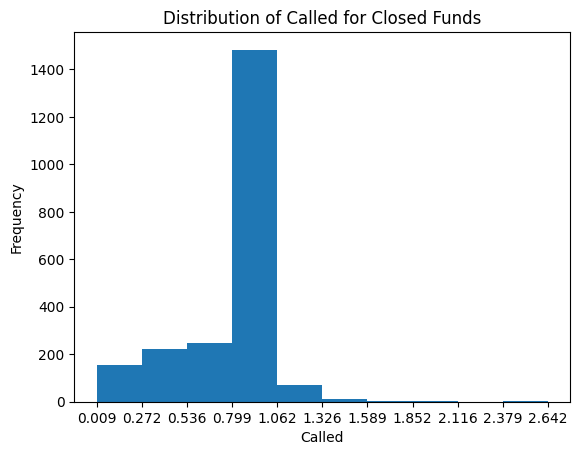

In [13]:
# Checking the distribution of percentage called for closed funds
# Filter the dataframe for 'status' equals 'Closed'
closed_funds = vc_returns[vc_returns['status'] == 'Closed']

# Plot the distribution of the 'called' column
plt.hist(closed_funds['called'], bins=10)
plt.xlabel('Called')
plt.ylabel('Frequency')
plt.title('Distribution of Called for Closed Funds')

# Add xticks
xticks = np.linspace(start=min(closed_funds['called']), stop=max(closed_funds['called']), num=11)
plt.xticks(xticks)

plt.show()

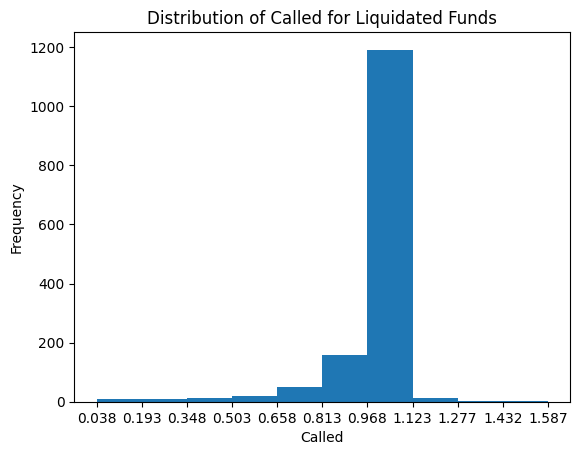

In [14]:
# Checking the distribution of percentage called for liquidated funds
# Filter the dataframe for 'status' equals 'Liquidated'
liquidated_funds = vc_returns[vc_returns['status'] == 'Liquidated']

# Plot the distribution of the 'called' column
plt.hist(liquidated_funds['called'], bins=10)
plt.xlabel('Called')
plt.ylabel('Frequency')
plt.title('Distribution of Called for Liquidated Funds')

# Add xticks
xticks = np.linspace(start=min(liquidated_funds['called']), stop=max(liquidated_funds['called']), num=11)
plt.xticks(xticks)

plt.show()

Given the distributions, we can include closed and liquidated funds with more than 75% of capital called in our analysis and exclude funds that have not closed.

In [15]:
# Drop funds that have not closed
vc_returns = vc_returns[vc_returns['status'].isin(['Closed', 'Liquidated'])]

# Drop funds that have less than 75% of capital called
vc_returns = vc_returns[vc_returns['called'] >= .75]

vc_returns.describe().round(2)

,firm_id,vintage,fund_size,irr,multiple,rvpi,dpi,called,date_reported,fund_manager_aum
count,3030.00,3030,2838.00,2521.00,2881.00,2926.00,2943.00,3030.00,3030,1586.00
mean,47704.54,2005-08-27 15:43:21.980198144,184.06,0.17,2.06,0.75,1.31,0.98,2021-06-18 18:57:44.554455552,16110.35
min,9.00,1969-01-01 00:00:00,0.14,-1.00,0.00,0.00,0.00,0.75,1996-09-30 00:00:00,1.00
25%,673.00,1999-01-01 00:00:00,30.89,0.03,1.01,0.00,0.20,0.96,2021-09-30 00:00:00,400.00
50%,6703.00,2006-01-01 00:00:00,87.60,0.12,1.52,0.22,0.84,1.00,2023-06-30 00:00:00,1300.00
75%,61134.00,2014-01-01 00:00:00,218.50,0.25,2.32,1.18,1.62,1.00,2023-09-30 00:00:00,3500.00
max,557578.00,2023-01-01 00:00:00,12700.00,10.16,38.72,29.26,38.33,2.64,2023-09-30 00:00:00,2154073.58
std,88195.69,NaN,365.81,0.38,2.33,1.21,2.19,0.09,NaN,108477.39


### Handling missing values

In [16]:
# Display the number of missing values in each column
vc_returns.isnull().sum()

firm_id                  0
name                     0
vintage                  0
strategy                 0
fund_size              192
irr                    509
multiple               149
rvpi                   104
dpi                     87
called                   0
date_reported            0
status                   0
geographic_focus        13
fund_manager             0
country                  5
core_industries         33
industry_verticals    2404
fund_manager_aum      1444
dtype: int64

In [17]:
# Removing 'industry_verticals' and 'fund_manager_aum' columns as they have too many missing values
vc_returns.drop('industry_verticals', axis=1, inplace=True)
vc_returns.drop('fund_manager_aum', axis=1, inplace=True)

# Handling missing values in categorical columns
vc_returns['geographic_focus'] = vc_returns['geographic_focus'].fillna('Unknown')
vc_returns['country'] = vc_returns['country'].fillna('Unknown')
vc_returns['core_industries'] = vc_returns['core_industries'].fillna('Unknown')

# Dropping rows with missing values in 'irr' column
vc_returns = vc_returns.dropna(subset=['irr'])

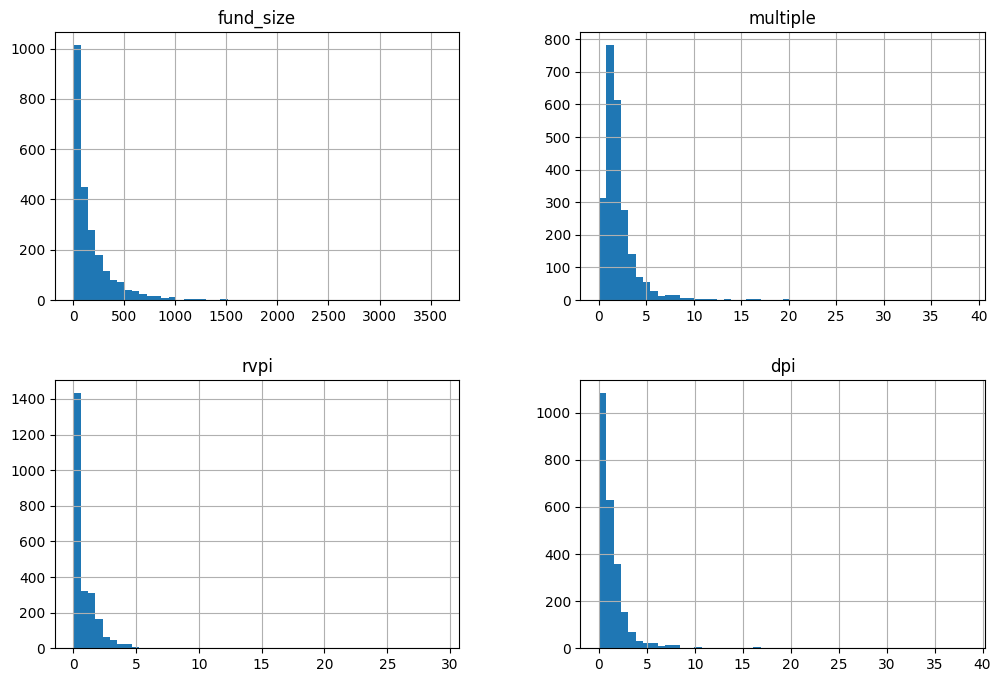

In [18]:
# Histogram to decide on imputation methods
vc_returns[['fund_size', 'multiple', 'rvpi', 'dpi']].hist(bins=50, figsize=(12, 8))
plt.show()

Based on the histograms, it's evident that the distributions of fund_size, multiple, rvpi, and dpi are right-skewed which is typical in VC datasets due to outlier funds that perform exceptionally well compared to the majority. These outliers can influence the mean so it is best to use the median for imputation.

In [19]:
# Imputing missing values in numeric columns with median
for col in ['fund_size', 'multiple', 'rvpi', 'dpi']:
    vc_returns[col] = vc_returns[col].fillna(vc_returns[col].median())

In [20]:
# Display the number of missing values in each column
vc_returns.isnull().sum()

firm_id             0
name                0
vintage             0
strategy            0
fund_size           0
irr                 0
multiple            0
rvpi                0
dpi                 0
called              0
date_reported       0
status              0
geographic_focus    0
fund_manager        0
country             0
core_industries     0
dtype: int64

In [21]:
# Display summary statistics
vc_returns.describe().round(2)

,firm_id,vintage,fund_size,irr,multiple,rvpi,dpi,called,date_reported
count,2521.00,2521,2521.00,2521.00,2521.00,2521.00,2521.00,2521.00,2521
mean,48977.19,2005-10-20 16:52:44.458548224,179.67,0.17,2.17,0.76,1.40,0.98,2021-10-27 21:48:03.141610496
min,9.00,1969-01-01 00:00:00,0.40,-1.00,0.00,0.00,0.00,0.75,2002-12-31 00:00:00
25%,658.00,1999-01-01 00:00:00,36.00,0.03,1.16,0.00,0.28,0.96,2022-03-31 00:00:00
50%,6642.00,2007-01-01 00:00:00,96.60,0.12,1.64,0.20,0.93,1.00,2023-06-30 00:00:00
75%,62076.00,2015-01-01 00:00:00,215.00,0.25,2.41,1.21,1.67,1.00,2023-09-30 00:00:00
max,557578.00,2020-01-01 00:00:00,3600.00,10.16,38.72,29.26,38.33,2.64,2023-09-30 00:00:00
std,89788.53,NaN,276.30,0.38,2.39,1.26,2.27,0.09,NaN


### Handling categorical variables
The categorical variables need to be converted into a format that can be used in statistical models. These will be put in a separate dataframe 'vc_returns_reg'. Strategy, status, geographic focus, and country have a single category per entry whereas core industries has multiple categories per entry which need to be parsed.

In [22]:
# Identify unique values in each categorical column
for col in ['strategy', 'status', 'geographic_focus', 'country', 'core_industries']:
    print(f"{col} has {vc_returns[col].nunique()} unique values")

print() 

# Display the unique values in each categorical column
for col in ['strategy', 'status', 'geographic_focus', 'country', 'core_industries']:
    print(f"{col}: {vc_returns[col].unique()}")

strategy has 5 unique values
status has 2 unique values
geographic_focus has 62 unique values
country has 58 unique values
core_industries has 23 unique values

strategy: ['Venture (General)' 'Early Stage' 'Early Stage: Seed'
 'Early Stage: Start-up' 'Expansion / Late Stage']
status: ['Liquidated' 'Closed']
geographic_focus: ['US' 'UK' 'North America' 'Northeast' 'South Africa' 'Canada' 'France'
 'Slovakia' 'Europe' 'Australia' 'West Europe' 'Nordic' 'India' 'Asia'
 'Israel' 'Taiwan - China' 'China' 'Norway' 'Central and East Europe'
 'Switzerland' 'South Korea' 'Denmark' 'Japan' 'Italy' 'Germany'
 'Greater China' 'Brazil' 'Africa' 'Spain' 'Finland' 'Unknown' 'Mexico'
 'Portugal' 'Middle East' 'East and Southeast Asia' 'Ghana'
 'Sub-Saharan Africa' 'Croatia' 'Netherlands' 'Hong Kong SAR - China'
 'Americas' 'Vietnam' 'Russia' 'Ireland' 'West' 'Singapore' 'Southeast'
 'Indonesia' 'Pakistan' 'Midwest' 'Turkey' 'Saudi Arabia' 'Southwest'
 'Australasia' 'Global' 'Greece' 'New Zealand' 'Lit

The single-category columns all have a managable number of unique categories for one-hot encoding. However,  we will first group geographic focus categories into broader regions, and merge some country variables.

In [23]:
# Define a mapping of terms to standardize geographic regions
# Categories include North America, Europe, Asia, Middle East, Africa, South America, Oceania, Multi-region/Global
geo_mapping = {
    'US': 'North America',
    'North America': 'North America',
    'Europe': 'Europe',
    'France': 'Europe',
    'Japan': 'Asia',
    'China': 'Asia',
    'UK': 'Europe',
    'Jordan': 'Middle East',
    'Middle East': 'Middle East',
    'South America': 'South America',
    'Northeast': 'North America', 
    'Israel': 'Middle East',
    'West Europe': 'Europe',
    'Asia': 'Asia',
    'South Africa': 'Africa',
    'Canada': 'North America',
    'Slovakia': 'Europe',
    'Australia': 'Oceania',
    'Nordic': 'Europe', 
    'Africa': 'Africa',
    'India': 'Asia',
    'China, Israel': 'Multi-region/Global',
    'Taiwan - China': 'Asia',
    'Peru': 'South America',
    'Spain': 'Europe',
    'Norway': 'Europe',
    'Central and East Europe': 'Europe',
    'Switzerland': 'Europe',
    'South Korea': 'Asia',
    'Denmark': 'Europe',
    'Brazil': 'South America',
    'Italy': 'Europe',
    'Emerging Markets': 'Multi-region/Global',
    'Poland': 'Europe',
    'Greater China': 'Asia',
    'Sub-Saharan Africa': 'Africa',
    'Germany': 'Europe',
    'Americas': 'Multi-region/Global',
    'Portugal': 'Europe',
    'Zambia': 'Africa',
    'Bulgaria': 'Europe',
    'Singapore': 'Asia',
    'Latvia': 'Europe',
    'Lithuania': 'Europe',
    'Finland': 'Europe',
    'Slovenia': 'Europe',
    'East and Southeast Asia': 'Asia',
    'Mexico': 'North America',
    'Thailand': 'Asia',
    'Sweden': 'Europe',
    'Netherlands': 'Europe',
    'Ghana': 'Africa',
    'Russia': 'Europe',
    'Croatia': 'Europe',
    'Ireland': 'Europe',
    'Hong Kong SAR - China': 'Asia',
    'United Arab Emirates': 'Middle East',
    'Midwest': 'North America', 
    'Vietnam': 'Asia',
    'West': 'North America',
    'Southeast': 'North America', 
    'Indonesia': 'Asia',
    'Pakistan': 'Asia',
    'Turkey': 'Europe', 
    'Saudi Arabia': 'Middle East',
    'Southwest': 'North America', 
    'Australasia': 'Oceania',
    'Global': 'Multi-region/Global',
    'Greece': 'Europe',
    'British Virgin Islands': 'North America',
    'Chile': 'South America',
    'New Zealand': 'Oceania',
    'Romania': 'Europe',
    'Belgium': 'Europe',
    'Macedonia': 'Europe',
    'North Africa': 'Africa',
    'Asia,Middle East': 'Multi-region/Global',
}

# Function to convert comma separated strings into lists
def split_categories(text):
    if not isinstance(text, str):
        return []
    return text.split(', ')

# Function to apply standardization and grouping
def standardize_geography(geo):
    geo_list = split_categories(geo)
    standardized_list = [geo_mapping.get(region.strip(), region.strip()) for region in geo_list]
    return ','.join(standardized_list)

# Apply the function to the 'geographic_focus' column
vc_returns['geographic_focus'] = vc_returns['geographic_focus'].apply(standardize_geography)

# Display the unique values in the 'geographic_focus' column
vc_returns['geographic_focus'].unique()

array(['North America', 'Europe', 'Africa', 'Oceania', 'Asia',
       'Middle East', 'South America', 'Unknown', 'Multi-region/Global'],
      dtype=object)

In [24]:
# Define a mapping of terms to merge same countries
country_mapping = {
    'United States': 'US',
    'Hong Kong SAR - China': 'China',
}

# Function to apply standardization and grouping
def standardize_country(country):
    country_list = split_categories(country)
    standardized_list = [country_mapping.get(region.strip(), region.strip()) for region in country_list]
    return ','.join(standardized_list)

# Apply the function to the 'country' column
vc_returns['country'] = vc_returns['country'].apply(standardize_country)

# Display the unique values in the 'country' column
vc_returns['country'].unique()

array(['US', 'UK', 'Canada', 'South Africa', 'France', 'Slovakia',
       'Denmark', 'Australia', 'India', 'Taiwan - China', 'Israel',
       'Spain', 'Belgium', 'China', 'Norway', 'Ukraine', 'Switzerland',
       'South Korea', 'Estonia', 'Germany', 'Croatia', 'Brazil', 'Russia',
       'Bulgaria', 'Netherlands', 'Unknown', 'Latvia', 'Finland',
       'Singapore', 'Portugal', 'United Arab Emirates', 'Japan', 'Italy',
       'Philippines', 'Ghana', 'Mexico', 'Austria', 'Indonesia',
       'Ireland', 'Sweden', 'Malaysia', 'Pakistan', 'Cayman Islands',
       'Luxembourg', 'Saudi Arabia', 'Hungary', 'Greece', 'Costa Rica',
       'Togo', 'Uruguay', 'Poland', 'Lithuania', 'Thailand',
       'New Zealand', 'Tunisia', 'Vietnam'], dtype=object)

In [25]:
# Identify unique values in each categorical column for encoding
for col in ['strategy', 'status', 'geographic_focus', 'country']:
    print(f"{col} has {vc_returns[col].nunique()} unique values")

print() 

# Display the unique values in each categorical column
for col in ['strategy', 'status', 'geographic_focus', 'country']:
    print(f"{col}: {vc_returns[col].unique()}")

strategy has 5 unique values
status has 2 unique values
geographic_focus has 9 unique values
country has 56 unique values

strategy: ['Venture (General)' 'Early Stage' 'Early Stage: Seed'
 'Early Stage: Start-up' 'Expansion / Late Stage']
status: ['Liquidated' 'Closed']
geographic_focus: ['North America' 'Europe' 'Africa' 'Oceania' 'Asia' 'Middle East'
 'South America' 'Unknown' 'Multi-region/Global']
country: ['US' 'UK' 'Canada' 'South Africa' 'France' 'Slovakia' 'Denmark'
 'Australia' 'India' 'Taiwan - China' 'Israel' 'Spain' 'Belgium' 'China'
 'Norway' 'Ukraine' 'Switzerland' 'South Korea' 'Estonia' 'Germany'
 'Croatia' 'Brazil' 'Russia' 'Bulgaria' 'Netherlands' 'Unknown' 'Latvia'
 'Finland' 'Singapore' 'Portugal' 'United Arab Emirates' 'Japan' 'Italy'
 'Philippines' 'Ghana' 'Mexico' 'Austria' 'Indonesia' 'Ireland' 'Sweden'
 'Malaysia' 'Pakistan' 'Cayman Islands' 'Luxembourg' 'Saudi Arabia'
 'Hungary' 'Greece' 'Costa Rica' 'Togo' 'Uruguay' 'Poland' 'Lithuania'
 'Thailand' 'New Zeala

In [26]:
# One-hot encoding the 'strategy', 'status', 'geographic_focus', and 'country' columns
strategy_dummies = pd.get_dummies(vc_returns['strategy'], prefix='strategy')
status_dummies = pd.get_dummies(vc_returns['status'], prefix='status')
geographic_focus_dummies = pd.get_dummies(vc_returns['geographic_focus'], prefix='geo_focus')
country_dummies = pd.get_dummies(vc_returns['country'], prefix='country')

# Concatenate the new dummy variables to a new dataframe
vc_returns_reg = pd.concat([vc_returns, strategy_dummies, status_dummies, geographic_focus_dummies, country_dummies], axis=1)

# Drop the original columns as they are now encoded
vc_returns_reg = vc_returns_reg.drop(columns=['strategy', 'status', 'geographic_focus', 'country'])

vc_returns_reg.head()

,firm_id,name,vintage,fund_size,irr,multiple,rvpi,dpi,called,date_reported,...,country_Thailand,country_Togo,country_Tunisia,country_UK,country_US,country_Ukraine,country_United Arab Emirates,country_Unknown,country_Uruguay,country_Vietnam
fund_id,,,,,,,,,,,,,,,,,,,,,
2103,506,Mesirow Capital Fund Assoc I,1985-01-01,96.60,-0.2850,0.240635,0.094635,0.146,1.00,2002-12-31,...,False,False,False,False,True,False,False,False,False,False
2651,8037,Korda Seed Capital Fund I,1989-01-01,8.43,0.1720,3.790000,0.400000,3.390,1.00,2003-03-31,...,False,False,False,True,False,False,False,False,False,False
57,14,Accel VII,1999-01-01,600.00,-0.2679,1.638206,0.200000,0.130,0.78,2003-03-31,...,False,False,False,False,True,False,False,False,False,False
6378,874,Cullinane & Donnelly Venture Partners,1987-01-01,96.60,0.0450,1.540000,0.070000,1.470,1.00,2003-03-31,...,False,False,False,False,True,False,False,False,False,False
1434,793,Pacven Ventures III,1994-01-01,105.00,0.0540,1.638206,0.200000,0.992,1.00,2003-09-30,...,False,False,False,False,True,False,False,False,False,False


In [27]:
# Convert boolean columns to numeric
for col in strategy_dummies.columns:
    vc_returns_reg[col] = vc_returns_reg[col].astype(int)

for col in status_dummies.columns:
    vc_returns_reg[col] = vc_returns_reg[col].astype(int)

for col in geographic_focus_dummies.columns:
    vc_returns_reg[col] = vc_returns_reg[col].astype(int)

for col in country_dummies.columns:
    vc_returns_reg[col] = vc_returns_reg[col].astype(int)

vc_returns_reg.head()

,firm_id,name,vintage,fund_size,irr,multiple,rvpi,dpi,called,date_reported,...,country_Thailand,country_Togo,country_Tunisia,country_UK,country_US,country_Ukraine,country_United Arab Emirates,country_Unknown,country_Uruguay,country_Vietnam
fund_id,,,,,,,,,,,,,,,,,,,,,
2103,506,Mesirow Capital Fund Assoc I,1985-01-01,96.60,-0.2850,0.240635,0.094635,0.146,1.00,2002-12-31,...,0,0,0,0,1,0,0,0,0,0
2651,8037,Korda Seed Capital Fund I,1989-01-01,8.43,0.1720,3.790000,0.400000,3.390,1.00,2003-03-31,...,0,0,0,1,0,0,0,0,0,0
57,14,Accel VII,1999-01-01,600.00,-0.2679,1.638206,0.200000,0.130,0.78,2003-03-31,...,0,0,0,0,1,0,0,0,0,0
6378,874,Cullinane & Donnelly Venture Partners,1987-01-01,96.60,0.0450,1.540000,0.070000,1.470,1.00,2003-03-31,...,0,0,0,0,1,0,0,0,0,0
1434,793,Pacven Ventures III,1994-01-01,105.00,0.0540,1.638206,0.200000,0.992,1.00,2003-09-30,...,0,0,0,0,1,0,0,0,0,0


In [28]:
# Ensure 'core_industries' column entries are lists and handle NaN values by replacing with an empty list
vc_returns_reg['core_industries'] = vc_returns_reg['core_industries'].apply(lambda x: [i.strip() for i in x.split(',')] if isinstance(x, str) else [])

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the 'core_industries' column
# The MultiLabelBinarizer will create a binary matrix of the presence of each industry
core_industries_encoded = mlb.fit_transform(vc_returns_reg['core_industries'])

# Check if the output is as expected
if core_industries_encoded.size == 0:
    raise ValueError("The MultiLabelBinarizer output is empty. There may be an issue with the input data.")

# Create a dataframe from the encoded binary matrix
core_industries_df = pd.DataFrame(core_industries_encoded, columns=mlb.classes_, index=vc_returns_reg.index)

# Add prefix 'core_industry_' to each column
core_industries_df.columns = ['core_industry_' + col for col in core_industries_df.columns]

# Concatenate the new dataframe with the original dataframe
vc_returns_reg = pd.concat([vc_returns_reg, core_industries_df], axis=1)

# Drop the original 'core_industries' column
vc_returns_reg = vc_returns_reg.drop(columns=['core_industries'])

vc_returns_reg.head()

,firm_id,name,vintage,fund_size,irr,multiple,rvpi,dpi,called,date_reported,...,core_industry_Diversified,core_industry_Energy & Utilities,core_industry_Financial & Insurance Services,core_industry_Healthcare,core_industry_Industrials,core_industry_Information Technology,core_industry_Raw Materials & Natural Resources,core_industry_Real Estate,core_industry_Telecoms & Media,core_industry_Unknown
fund_id,,,,,,,,,,,,,,,,,,,,,
2103,506,Mesirow Capital Fund Assoc I,1985-01-01,96.60,-0.2850,0.240635,0.094635,0.146,1.00,2002-12-31,...,0,0,0,0,0,0,0,0,0,1
2651,8037,Korda Seed Capital Fund I,1989-01-01,8.43,0.1720,3.790000,0.400000,3.390,1.00,2003-03-31,...,0,0,0,0,0,1,0,0,0,0
57,14,Accel VII,1999-01-01,600.00,-0.2679,1.638206,0.200000,0.130,0.78,2003-03-31,...,0,0,0,0,0,1,0,0,0,0
6378,874,Cullinane & Donnelly Venture Partners,1987-01-01,96.60,0.0450,1.540000,0.070000,1.470,1.00,2003-03-31,...,0,0,0,0,0,1,0,0,0,0
1434,793,Pacven Ventures III,1994-01-01,105.00,0.0540,1.638206,0.200000,0.992,1.00,2003-09-30,...,1,0,0,0,0,0,0,0,0,0


### Checking for outliers

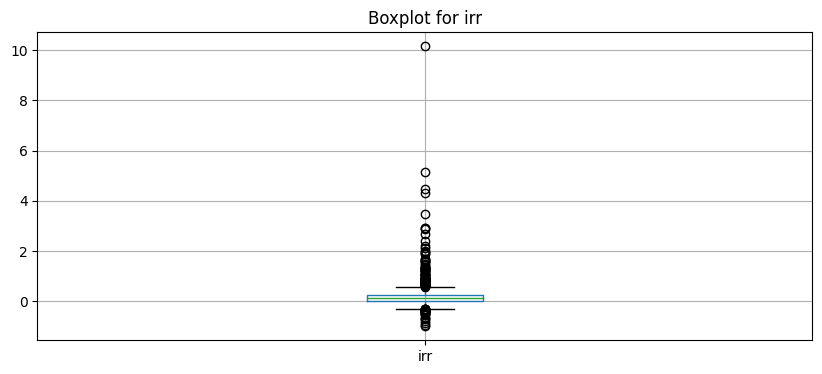

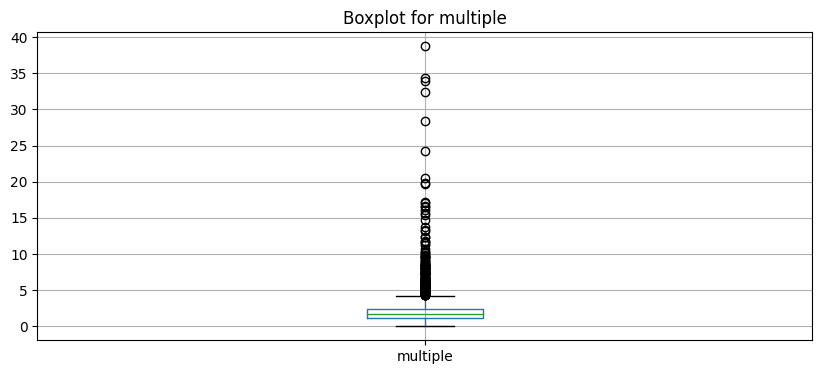

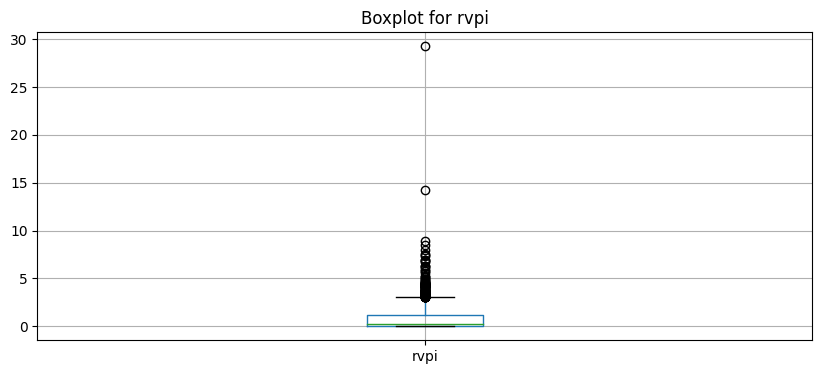

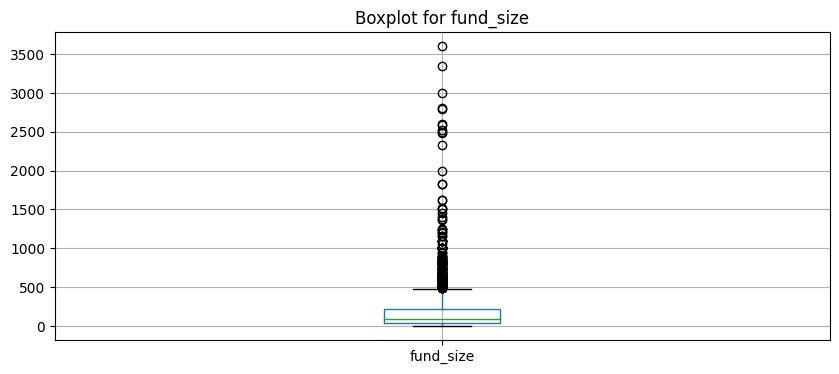

In [29]:
# List of key columns to check for outliers
key_columns = ['irr', 'multiple', 'rvpi', 'fund_size']

# Plot boxplots to visualize outliers
for col in key_columns:
    plt.figure(figsize=(10, 4))
    vc_returns.boxplot(column=col)
    plt.title(f"Boxplot for {col}")
    plt.show()

### Market Data

In [30]:
# Reading the excel file
raw_market_data = pd.read_excel('data/histretSP.xlsx', sheet_name='S&P 500 & Raw Data', skiprows=1)
raw_market_data.head()

/Users/deniz/miniconda3/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,Year,S&P 500,Dividends,Dividend Yield,T.Bond rate,Return on bond,Aaa Bond Rate,Return on Aaa,Baa Bond Rate,Return on Baa,Returns on Real Estate,Unnamed: 11,Jan 1 notes
0,1927,17.66,0.61810,0.035,0.0317,NaN,0.0446,NaN,0.0532,NaN,NaN,NaN,NaN
1,1928,24.35,1.04705,0.043,0.0345,0.008355,0.0461,0.032795,0.0560,0.032196,0.014911,NaN,NaN
2,1929,21.45,0.87945,0.041,0.0336,0.042038,0.0467,0.041392,0.0595,0.030179,-0.020568,NaN,NaN
3,1930,15.34,0.72098,0.047,0.0322,0.045409,0.0452,0.058557,0.0671,0.005398,-0.043000,NaN,NaN
4,1931,8.12,0.49532,0.061,0.0393,-0.025589,0.0532,-0.015625,0.1042,-0.156808,-0.081505,NaN,NaN


In [31]:
# Convert year column to datetime
raw_market_data['Year'] = pd.to_datetime(raw_market_data['Year'], format='%Y')

# Only keep necessary columns
market_data = raw_market_data[['Year', 'S&P 500', 'T.Bond rate']]

# Rename columns
market_data.rename(columns={'Year': 'year', 'S&P 500': 'mkt', 'T.Bond rate': 'rf'}, inplace=True)

# Set year as index
market_data.set_index('year', inplace=True)

# Calculate returns for the market
market_data['mkt'] = market_data['mkt'].pct_change()

market_data.head()

/var/folders/47/h5_s7vcs6dqdzfk1gltbb0p80000gn/T/ipykernel_10958/1823824533.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_data.rename(columns={'Year': 'year', 'S&P 500': 'mkt', 'T.Bond rate': 'rf'}, inplace=True)
/var/folders/47/h5_s7vcs6dqdzfk1gltbb0p80000gn/T/ipykernel_10958/1823824533.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_data['mkt'] = market_data['mkt'].pct_change()


,mkt,rf
year,,
1927-01-01,NaN,0.0317
1928-01-01,0.378822,0.0345
1929-01-01,-0.119097,0.0336
1930-01-01,-0.284848,0.0322
1931-01-01,-0.470665,0.0393


In [32]:
# Display summary statistics
market_data.describe().round(2)

,mkt,rf
count,95.00,96.00
mean,0.08,0.05
std,0.19,0.03
min,-0.47,0.01
25%,-0.06,0.03
50%,0.11,0.04
75%,0.21,0.06
max,0.45,0.14


In [33]:
# Check for missing values
market_data.isnull().sum()

mkt    1
rf     0
dtype: int64

In [34]:
# Drop missing values
market_data = market_data.dropna()
market_data.head()

,mkt,rf
year,,
1928-01-01,0.378822,0.0345
1929-01-01,-0.119097,0.0336
1930-01-01,-0.284848,0.0322
1931-01-01,-0.470665,0.0393
1932-01-01,-0.147783,0.0335


In [35]:
market_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95 entries, 1928-01-01 to 2022-01-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mkt     95 non-null     float64
 1   rf      95 non-null     float64
dtypes: float64(2)
memory usage: 2.2 KB


### Fama French 5-Factor Data

In [36]:
# Date parser function
def parse_date(date_str):
    return pd.to_datetime(date_str, format='%Y%m')

# Read the Fama French 5-factor data
ff5_data = pd.read_csv('data/FF_5_Factor.csv', header=2, parse_dates=[0], 
                       index_col=0, date_parser=parse_date, nrows=716)

ff5_data.head()

/var/folders/47/h5_s7vcs6dqdzfk1gltbb0p80000gn/T/ipykernel_10958/1350439175.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5_data = pd.read_csv('data/FF_5_Factor.csv', header=2, parse_dates=[0],


,Mkt-RF,SMB,HML,RMW,CMA,RF
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27


In [37]:
# Convert the returns to decimal
ff5_data = ff5_data / 100

# Convert the data to annual frequency
ff5_data = ff5_data.resample('Y').last().shift(1, freq='D')
ff5_data.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
1964-01-01,0.0183,-0.0210,-0.0002,0.0003,-0.0007,0.0029
1965-01-01,0.0003,-0.0069,-0.0248,0.0107,-0.0150,0.0031
1966-01-01,0.0101,0.0266,0.0203,-0.0114,-0.0053,0.0033
1967-01-01,0.0013,0.0202,-0.0119,0.0070,-0.0034,0.0040
1968-01-01,0.0305,0.0575,-0.0053,-0.0081,0.0013,0.0033


In [38]:
ff5_data.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 1964-01-01 to 2024-01-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  61 non-null     float64
 1   SMB     61 non-null     float64
 2   HML     61 non-null     float64
 3   RMW     61 non-null     float64
 4   CMA     61 non-null     float64
 5   RF      61 non-null     float64
dtypes: float64(6)
memory usage: 3.3 KB


### Time Series
Creating a dataframe that has time series for each fund's life cycle to be used in later calculations.

In [39]:
# Create a column for ending year
vc_returns['effective_end_year'] = vc_returns['date_reported'].apply(lambda x: min(x.year, 2022))

# Ensure it is in datetime format
vc_returns['effective_end_year'] = pd.to_datetime(vc_returns['effective_end_year'], format='%Y')

# Create a column for effective investment period
vc_returns['investment_period'] = vc_returns['effective_end_year'].dt.year - vc_returns['vintage'].dt.year

vc_returns['investment_period'].describe().round(0)

count    2521.0
mean       15.0
std        10.0
min         0.0
25%         6.0
50%        12.0
75%        22.0
max        53.0
Name: investment_period, dtype: float64

The dataset does not include the actual date of performance. For instance, a fund that vintaged in 1969 can show the reported date as 2023 because Preqin only confirms the performance remains the same as of 2023. Because of this, some funds have extremely long life cycles. We need to filter these out. According to an article from Institutional Investor, average lifespan of a venture capital fund is 14 years.\
https://www.institutionalinvestor.com/article/2bsv31916hb46dpp501ds/portfolio/the-new-reality-of-the-14-year-venture-capital-fund

In [40]:
# Update effective_end_year and investment_period for funds with investment period greater than 20 years
vc_returns.loc[vc_returns['investment_period'] > 20, 'effective_end_year'] = vc_returns['vintage'].dt.year + 14

# Convert to datetime again
vc_returns['effective_end_year'] = pd.to_datetime(vc_returns['effective_end_year'], format='%Y')

# Update investment_period
vc_returns['investment_period'] = vc_returns['effective_end_year'].dt.year - vc_returns['vintage'].dt.year

vc_returns['investment_period'].describe().round(0)

count    2521.0
mean       11.0
std         5.0
min         0.0
25%         6.0
50%        12.0
75%        14.0
max        20.0
Name: investment_period, dtype: float64

In [41]:
# Initialize an empty list to store data
time_series_data = []

# Iterate over each fund in vc_returns
for fund_id, row in vc_returns.iterrows():
    vintage_year = row['vintage'].year
    fund_life_years = range(vintage_year, row['effective_end_year'].year + 1)

    for year in fund_life_years:
        if pd.Timestamp(year=year, month=1, day=1) in market_data.index:
            mkt = market_data.loc[pd.Timestamp(year=year, month=1, day=1), 'mkt']
            rf = market_data.loc[pd.Timestamp(year=year, month=1, day=1), 'rf']
            time_series_data.append({
                'fund_id': fund_id,
                'irr': row['irr'],
                'year': year,
                'mkt': mkt,
                'rf': rf,
            })

# Convert list to dataframe
time_series_df = pd.DataFrame(time_series_data)

time_series_df.head()

,fund_id,irr,year,mkt,rf
0,2103,-0.285,1985,0.263334,0.0926
1,2103,-0.285,1986,0.146204,0.0711
2,2103,-0.285,1987,0.020275,0.0899
3,2103,-0.285,1988,0.124008,0.0911
4,2103,-0.285,1989,0.272505,0.0784


In [42]:
time_series_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29030 entries, 0 to 29029
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   fund_id  29030 non-null  int64  
 1   irr      29030 non-null  float64
 2   year     29030 non-null  int64  
 3   mkt      29030 non-null  float64
 4   rf       29030 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 1.1 MB


In [43]:
# Create a separate dataframe for 5-factor data
ff5_time_series = time_series_df.drop(columns=['mkt', 'rf'])

# Convert 'year' column to datetime
ff5_time_series['year'] = pd.to_datetime(ff5_time_series['year'], format='%Y')

# Merge the 5-factor data with the time series data
ff5_time_series = ff5_time_series.merge(ff5_data, how='left', left_on='year', right_index=True)

ff5_time_series.head()

,fund_id,irr,year,Mkt-RF,SMB,HML,RMW,CMA,RF
0,2103,-0.285,1985-01-01,0.0184,-0.0065,-0.0026,0.0131,-0.0136,0.0064
1,2103,-0.285,1986-01-01,0.0388,-0.0041,-0.0154,0.0099,-0.0180,0.0065
2,2103,-0.285,1987-01-01,-0.0327,0.0012,0.0036,0.0079,0.0009,0.0049
3,2103,-0.285,1988-01-01,0.0681,0.0006,-0.0443,0.0296,-0.0242,0.0039
4,2103,-0.285,1989-01-01,0.0149,0.0201,-0.0169,0.0069,-0.0038,0.0063


## Simplified PME

In [44]:
# Calculate market return compounding factor 1+r
market_data['mkt_x'] = (1 + market_data['mkt'])

market_data.head()

,mkt,rf,mkt_x
year,,,
1928-01-01,0.378822,0.0345,1.378822
1929-01-01,-0.119097,0.0336,0.880903
1930-01-01,-0.284848,0.0322,0.715152
1931-01-01,-0.470665,0.0393,0.529335
1932-01-01,-0.147783,0.0335,0.852217


In [45]:
# Function to calculate PME
def calculate_pme_and_metrics(row, market_data):
    vintage_year = row['vintage'].year
    effective_end_year = row['effective_end_year'].year

    if str(vintage_year) in market_data.index and str(effective_end_year) in market_data.index:
        market_cum_return = market_data.loc[str(vintage_year):str(effective_end_year), 'mkt_x'].prod()
        market_cagr = (market_cum_return ** (1 / row['investment_period'])) - 1 if row['investment_period'] > 0 else 0

        pme = (1 + row['irr']) / (1 + market_cagr) if market_cagr != 0 else None
        return pme, market_cagr, market_cum_return
    else:
        return None, None, None

# Apply the function and assign new columns
vc_returns[['pme', 'market_cagr', 'market_cum_return']] = vc_returns.apply(lambda row: calculate_pme_and_metrics(row, market_data), axis=1, result_type='expand')

In [46]:
vc_returns.head()

,firm_id,name,vintage,strategy,fund_size,irr,multiple,rvpi,dpi,called,...,status,geographic_focus,fund_manager,country,core_industries,effective_end_year,investment_period,pme,market_cagr,market_cum_return
fund_id,,,,,,,,,,,,,,,,,,,,,
2103,506,Mesirow Capital Fund Assoc I,1985-01-01,Venture (General),96.60,-0.2850,0.240635,0.094635,0.146,1.00,...,Liquidated,North America,Mesirow Financial,US,Unknown,2002-01-01,17,0.648472,0.102592,5.260823
2651,8037,Korda Seed Capital Fund I,1989-01-01,Venture (General),8.43,0.1720,3.790000,0.400000,3.390,1.00,...,Liquidated,Europe,Korda & Company,UK,Information Technology,2003-01-01,14,1.061438,0.104163,4.003709
57,14,Accel VII,1999-01-01,Venture (General),600.00,-0.2679,1.638206,0.200000,0.130,0.78,...,Liquidated,North America,Accel,US,Information Technology,2003-01-01,4,0.750691,-0.024765,0.904558
6378,874,Cullinane & Donnelly Venture Partners,1987-01-01,Early Stage,96.60,0.0450,1.540000,0.070000,1.470,1.00,...,Liquidated,North America,Cullinane & Donnelly,US,Information Technology,2003-01-01,16,0.950046,0.099947,4.591444
1434,793,Pacven Ventures III,1994-01-01,Early Stage,105.00,0.0540,1.638206,0.200000,0.992,1.00,...,Liquidated,North America,Walden Catalyst,US,Diversified,2003-01-01,9,0.957023,0.101332,2.383771


In [47]:
# Check for missing values
vc_returns.isnull().sum()

firm_id               0
name                  0
vintage               0
strategy              0
fund_size             0
irr                   0
multiple              0
rvpi                  0
dpi                   0
called                0
date_reported         0
status                0
geographic_focus      0
fund_manager          0
country               0
core_industries       0
effective_end_year    0
investment_period     0
pme                   9
market_cagr           0
market_cum_return     0
dtype: int64

In [48]:
# Drop rows with missing pme values
vc_returns = vc_returns.dropna(subset=['pme'])

In [49]:
# Add pme to the vc_returns_reg dataframe
vc_returns_reg = vc_returns_reg.merge(vc_returns[['pme']], how='left', left_index=True, right_index=True)

vc_returns_reg.head()

,firm_id,name,vintage,fund_size,irr,multiple,rvpi,dpi,called,date_reported,...,core_industry_Energy & Utilities,core_industry_Financial & Insurance Services,core_industry_Healthcare,core_industry_Industrials,core_industry_Information Technology,core_industry_Raw Materials & Natural Resources,core_industry_Real Estate,core_industry_Telecoms & Media,core_industry_Unknown,pme
fund_id,,,,,,,,,,,,,,,,,,,,,
2103,506,Mesirow Capital Fund Assoc I,1985-01-01,96.60,-0.2850,0.240635,0.094635,0.146,1.00,2002-12-31,...,0,0,0,0,0,0,0,0,1,0.648472
2651,8037,Korda Seed Capital Fund I,1989-01-01,8.43,0.1720,3.790000,0.400000,3.390,1.00,2003-03-31,...,0,0,0,0,1,0,0,0,0,1.061438
57,14,Accel VII,1999-01-01,600.00,-0.2679,1.638206,0.200000,0.130,0.78,2003-03-31,...,0,0,0,0,1,0,0,0,0,0.750691
6378,874,Cullinane & Donnelly Venture Partners,1987-01-01,96.60,0.0450,1.540000,0.070000,1.470,1.00,2003-03-31,...,0,0,0,0,1,0,0,0,0,0.950046
1434,793,Pacven Ventures III,1994-01-01,105.00,0.0540,1.638206,0.200000,0.992,1.00,2003-09-30,...,0,0,0,0,0,0,0,0,0,0.957023


In [50]:
vc_returns_reg.isnull().sum()

firm_id                                            0
name                                               0
vintage                                            0
fund_size                                          0
irr                                                0
                                                  ..
core_industry_Raw Materials & Natural Resources    0
core_industry_Real Estate                          0
core_industry_Telecoms & Media                     0
core_industry_Unknown                              0
pme                                                9
Length: 96, dtype: int64

In [51]:
vc_returns_reg = vc_returns_reg.dropna(subset=['pme'])

### Multicollinearity check before regression

In [52]:
# Ensure all variables are numeric. Convert boolean columns to integers and exclude non-numeric columns.
vc_returns_numeric = vc_returns_reg.select_dtypes(include=[np.number])

# Add a constant for the intercept
X = add_constant(vc_returns_numeric)

# Create a new dataframe for VIF results
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

# Display VIF values
pd.set_option('display.max_rows', None)
print(vif)

/Users/deniz/miniconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


/Users/deniz/miniconda3/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/deniz/miniconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


    VIF Factor                                         features
0     0.000000                                            const
1     1.561055                                          firm_id
2     1.177628                                        fund_size
3    57.899025                                              irr
4    52.755151                                         multiple
5    15.506248                                             rvpi
6    47.129548                                              dpi
7     1.068636                                           called
8          inf                             strategy_Early Stage
9          inf                       strategy_Early Stage: Seed
10         inf                   strategy_Early Stage: Start-up
11         inf                  strategy_Expansion / Late Stage
12         inf                       strategy_Venture (General)
13         inf                                    status_Closed
14         inf                          

There are infinite VIF values in the encoded columns and high values in performance metrics. We'll look at the significance of the categorical variables to decide on potential changes. Then, we will deal with the performance metrics.

In [53]:
# Filter columns based on column names
filtered_columns = vc_returns_reg.filter(regex='^(geo_focus|core_industry|strategy|status|country)').columns

# Count the number of fund counts by each category
counts = vc_returns_reg[filtered_columns].sum()

# Display the counts
print(counts)

strategy_Early Stage                                693
strategy_Early Stage: Seed                          181
strategy_Early Stage: Start-up                      121
strategy_Expansion / Late Stage                     198
strategy_Venture (General)                         1319
status_Closed                                      1375
status_Liquidated                                  1137
geo_focus_Africa                                     18
geo_focus_Asia                                      350
geo_focus_Europe                                    318
geo_focus_Middle East                                58
geo_focus_Multi-region/Global                         5
geo_focus_North America                            1700
geo_focus_Oceania                                    40
geo_focus_South America                              11
geo_focus_Unknown                                    12
country_Australia                                    39
country_Austria                                 

Dropping country and status columns to reduce multicollinearity as they are of lower importance for the analysis. Also dropping the 'Unknown' values in geo_focus and core_industry.

In [54]:
# Drop the country and status columns
vc_returns_reg = vc_returns_reg.drop(columns=vc_returns_reg.filter(regex='^(country|status)').columns)

# Dropping one dummy variable from geo focus and core industry
vc_returns_reg = vc_returns_reg.drop(columns=['geo_focus_Unknown', 'core_industry_Unknown'])

As Venture (General) encompasses all categories, it is likely causing the infinite values. Dropping this category and combining Early Stage: Seed and Early Stage: Startup under Early Stage. Removing Venture (General) and checking both strategies for the constituents.

In [55]:
# Turn 'Early Stage: Seed' and 'Early Stage: Start-up' into 'Early Stage'
vc_returns_reg.loc[vc_returns_reg['strategy_Early Stage'] != 1, 'strategy_Early Stage'] = vc_returns_reg['strategy_Early Stage: Seed'] | vc_returns_reg['strategy_Early Stage: Start-up']

# Drop the original 'Early Stage: Seed' and 'Early Stage: Start-up' columns
vc_returns_reg = vc_returns_reg.drop(columns=['strategy_Early Stage: Seed', 'strategy_Early Stage: Start-up'])

vc_returns_reg.columns

Index(['firm_id', 'name', 'vintage', 'fund_size', 'irr', 'multiple', 'rvpi',
       'dpi', 'called', 'date_reported', 'fund_manager',
       'strategy_Early Stage', 'strategy_Expansion / Late Stage',
       'strategy_Venture (General)', 'geo_focus_Africa', 'geo_focus_Asia',
       'geo_focus_Europe', 'geo_focus_Middle East',
       'geo_focus_Multi-region/Global', 'geo_focus_North America',
       'geo_focus_Oceania', 'geo_focus_South America',
       'core_industry_Business Services',
       'core_industry_Consumer Discretionary', 'core_industry_Diversified',
       'core_industry_Energy & Utilities',
       'core_industry_Financial & Insurance Services',
       'core_industry_Healthcare', 'core_industry_Industrials',
       'core_industry_Information Technology',
       'core_industry_Raw Materials & Natural Resources',
       'core_industry_Real Estate', 'core_industry_Telecoms & Media', 'pme'],
      dtype='object')

In [56]:
# Check counts for strategy
filtered_columns = vc_returns_reg.filter(regex='^(strategy)').columns
counts = vc_returns_reg[filtered_columns].sum()
print(counts)

strategy_Early Stage                995
strategy_Expansion / Late Stage     198
strategy_Venture (General)         1319
dtype: int64


In [57]:
# For Venture (General), check all categories
vc_returns_reg.loc[vc_returns_reg['strategy_Venture (General)'] == 1, filtered_columns] = 1

# Drop the Venture (General) column
vc_returns_reg = vc_returns_reg.drop(columns=['strategy_Venture (General)'])

In [58]:
# Check counts
filtered_columns = vc_returns_reg.filter(regex='^(strategy)').columns
counts = vc_returns_reg[filtered_columns].sum()
print(counts)

strategy_Early Stage               2314
strategy_Expansion / Late Stage    1517
dtype: int64


In [59]:
# Check for multicollinearity again
vc_returns_numeric = vc_returns_reg.select_dtypes(include=[np.number])
X = add_constant(vc_returns_numeric)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
pd.set_option('display.max_rows', None)
print(vif)

    VIF Factor                                         features
0   669.828329                                            const
1     1.364616                                          firm_id
2     1.090303                                        fund_size
3    51.488235                                              irr
4    51.167169                                         multiple
5    14.862840                                             rvpi
6    45.667537                                              dpi
7     1.035209                                           called
8     1.085117                             strategy_Early Stage
9     1.172627                  strategy_Expansion / Late Stage
10    2.603555                                 geo_focus_Africa
11   27.455872                                   geo_focus_Asia
12   25.493286                                 geo_focus_Europe
13    5.973003                            geo_focus_Middle East
14    1.422719                    geo_fo

Geographic focus categories still have high multicollinearity, will try combining regions with lower counts.

In [60]:
# Get all 'geo_focus' columns
geo_focus_columns = vc_returns_reg.filter(regex='^(geo_focus)').columns

# Columns to keep
keep_columns = ['geo_focus_North America', 'geo_focus_Europe', 'geo_focus_Asia']

# Columns to combine into 'geo_focus_Other'
other_columns = [col for col in geo_focus_columns if col not in keep_columns]

# Combine 'geo_focus_Middle East' into 'geo_focus_Asia'
vc_returns_reg['geo_focus_Asia'] = vc_returns_reg['geo_focus_Asia'] | vc_returns_reg['geo_focus_Middle East']

# Create 'geo_focus_Other' column
vc_returns_reg['geo_focus_Other'] = vc_returns_reg[other_columns].max(axis=1)

# Drop the other 'geo_focus' columns
vc_returns_reg = vc_returns_reg.drop(columns=other_columns)

In [61]:
# Check counts
geo_focus_columns = vc_returns_reg.filter(regex='^(geo_focus)').columns
counts = vc_returns_reg[geo_focus_columns].sum()
print(counts)

geo_focus_Asia              408
geo_focus_Europe            318
geo_focus_North America    1700
geo_focus_Other             132
dtype: int64


In [62]:
# Check for multicollinearity again
vc_returns_numeric = vc_returns_reg.select_dtypes(include=[np.number])
X = add_constant(vc_returns_numeric)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
pd.set_option('display.max_rows', None)
print(vif)

    VIF Factor                                         features
0   539.920293                                            const
1     1.362739                                          firm_id
2     1.090008                                        fund_size
3    51.063944                                              irr
4    51.157290                                         multiple
5    14.851739                                             rvpi
6    45.656512                                              dpi
7     1.034732                                           called
8     1.081229                             strategy_Early Stage
9     1.168773                  strategy_Expansion / Late Stage
10    8.035014                                   geo_focus_Asia
11    7.942876                                 geo_focus_Europe
12   14.456939                          geo_focus_North America
13    1.078501                  core_industry_Business Services
14    1.232967             core_industry

The VIF results indicate that the multiple, rvpi, and dpi columns have high VIF factors, suggesting multicollinearity. DPI and multiple are highly correlated. The difference stems from the LP's remaining interest in the partnership that is included in the multiple (the unrealized return).

In [63]:
# Drop the 'dpi' column
vc_returns_reg = vc_returns_reg.drop(columns=['dpi'])

# Check for multicollinearity again
vc_returns_numeric = vc_returns_reg.select_dtypes(include=[np.number])
X = add_constant(vc_returns_numeric)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif.round(1))

    VIF Factor                                         features
0        539.9                                            const
1          1.4                                          firm_id
2          1.1                                        fund_size
3         51.1                                              irr
4          1.5                                         multiple
5          1.5                                             rvpi
6          1.0                                           called
7          1.1                             strategy_Early Stage
8          1.2                  strategy_Expansion / Late Stage
9          8.0                                   geo_focus_Asia
10         7.9                                 geo_focus_Europe
11        14.5                          geo_focus_North America
12         1.1                  core_industry_Business Services
13         1.2             core_industry_Consumer Discretionary
14         3.4                        co

Dropping dpi significantly reduced multicollinearity. Excluding this metric from our regression analysis while keeping the multiple. PME and IRR are highly correlated as expected. We will use PME as the dependent variable and exclude IRR from the regression.

In [64]:
# Drop irr column
vc_returns_reg = vc_returns_reg.drop(columns=['irr'])

# Check for multicollinearity again
vc_returns_numeric = vc_returns_reg.select_dtypes(include=[np.number])
X = add_constant(vc_returns_numeric)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif.round(1))

    VIF Factor                                         features
0        238.4                                            const
1          1.3                                          firm_id
2          1.1                                        fund_size
3          1.5                                         multiple
4          1.4                                             rvpi
5          1.0                                           called
6          1.1                             strategy_Early Stage
7          1.2                  strategy_Expansion / Late Stage
8          8.0                                   geo_focus_Asia
9          7.9                                 geo_focus_Europe
10        14.5                          geo_focus_North America
11         1.1                  core_industry_Business Services
12         1.2             core_industry_Consumer Discretionary
13         3.4                        core_industry_Diversified
14         1.3                 core_indu

Successfully decreased the multicollinearity values to acceptable levels except for the geo_focus_North America category. The results of the regression should be interpreted with caution.

### Regression

In [101]:
# Select only numeric columns for the regression, excluding 'pme'
numeric_columns = vc_returns_reg.select_dtypes(include=[np.number]).columns.drop('pme')

# Prepare the data for regression
X = vc_returns_reg[numeric_columns]
X = sm.add_constant(X) 
Y = vc_returns_reg['pme']

# Perform the regression
model = sm.OLS(Y, X).fit()

# Display the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    pme   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     39.28
Date:                Fri, 29 Dec 2023   Prob (F-statistic):          2.88e-143
Time:                        13:35:46   Log-Likelihood:                -598.23
No. Observations:                2512   AIC:                             1242.
Df Residuals:                    2489   BIC:                             1377.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

## CAPM Alpha

### From formula
Deriving CAPM alpha from the formula just for reference. Using a beta of 2.2 calculated in a SHE paper. \
CAPM alpha = Fund IRR - Risk-free rate - Beta (Market return - Risk-free rate)

In [66]:
# Prepare a list to collect data
formula_capm_list = []

for index, row in vc_returns.iterrows():
    vintage_year = row['vintage'].year
    report_year = min(row['date_reported'].year, vintage_year + 10, 2022)
    
    for year in range(vintage_year, report_year + 1):
        if year in market_data.index.year:
            market_return = market_data[market_data.index.year == year]['mkt'].values[0]
            risk_free_rate = market_data[market_data.index.year == year]['rf'].values[0]
            fund_return = row['irr']
            alpha = fund_return - risk_free_rate - 2.2 * (market_return - risk_free_rate)  # assuming beta = 2.2
            formula_capm_list.append({
                'fund_id': row.name,
                'year': year,
                'alpha': alpha
            })

# Convert list to dataframe
formula_capm = pd.DataFrame(formula_capm_list)

formula_capm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22789 entries, 0 to 22788
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   fund_id  22789 non-null  int64  
 1   year     22789 non-null  int64  
 2   alpha    22789 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 534.2 KB


In [67]:
formula_capm.describe().round(2)

,fund_id,year,alpha
count,22789.00,22789.00,22789.00
mean,24829.30,2008.12,0.02
std,33211.27,9.26,0.54
min,11.00,1969.00,-1.53
25%,2280.00,2002.00,-0.31
50%,8170.00,2009.00,-0.07
75%,38199.00,2016.00,0.25
max,184113.00,2022.00,11.03


### Regression

In [68]:
# Calculate market premium and excess return
time_series_df['mkt_premium'] = time_series_df['mkt'] - time_series_df['rf']

# Calculate excess return
time_series_df['excess_return'] = time_series_df['irr'] - time_series_df['rf']

time_series_df.head()

,fund_id,irr,year,mkt,rf,mkt_premium,excess_return
0,2103,-0.285,1985,0.263334,0.0926,0.170734,-0.3776
1,2103,-0.285,1986,0.146204,0.0711,0.075104,-0.3561
2,2103,-0.285,1987,0.020275,0.0899,-0.069625,-0.3749
3,2103,-0.285,1988,0.124008,0.0911,0.032908,-0.3761
4,2103,-0.285,1989,0.272505,0.0784,0.194105,-0.3634


#### Average by fund life
In this simplified model, we use use the average excess return and average market premium over the life of each funds, treating each fund as a single data point

In [69]:
# Calculate average excess return and market premium for each fund
avg_data = time_series_df.groupby('fund_id').agg({'excess_return': 'mean', 'mkt_premium': 'mean'}).reset_index()

# Prepare the data for regression
X = sm.add_constant(avg_data['mkt_premium'])
Y = avg_data['excess_return']

# Perform the regression
model = sm.OLS(Y, X).fit()

# Display the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     43.04
Date:                Thu, 28 Dec 2023   Prob (F-statistic):           6.48e-11
Time:                        18:53:39   Log-Likelihood:                -1130.4
No. Observations:                2521   AIC:                             2265.
Df Residuals:                    2519   BIC:                             2276.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0709      0.013      5.390      

The results indicate a positive relationship between excess returns of venture funds and the market premium with a positive beta of 1.2324 and alpha of 7.09%. However, the model has a low R-squared value, suggesting around 1.7% of the variation in the excess returns is explained by the market premium. 

#### Separate regression for each fund
Regression for each fund's excess return and market premium throughout the investment period, using all the data points. This is still a simplified model because we only have a single IRR for each fund.

In [70]:
def run_regression(group):
    X = sm.add_constant(group['mkt_premium'])
    y = group['excess_return']

    model = sm.OLS(y, X)
    try:
        results = model.fit()
        return {
            'alpha': results.params.get('const', None),
            'beta': results.params.get('mkt_premium', None),
            'r_squared': results.rsquared,
            'p_value': results.pvalues.get('mkt_premium', None)
        }
    except ValueError:  # Handle any exceptions, such as singular matrix errors
        return {'alpha': None, 'beta': None, 'r_squared': None, 'p_value': None}


In [71]:
group_regression_results = time_series_df.groupby('fund_id').apply(run_regression)
summary_df = pd.DataFrame(list(group_regression_results))

/Users/deniz/miniconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/deniz/miniconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/deniz/miniconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/deniz/miniconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/deniz/miniconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/deniz/m

In [72]:
summary_df.describe()

,alpha,beta,r_squared,p_value
count,2512.000000,2521.000000,2515.000000,2495.000000
mean,0.140459,0.009054,-inf,0.359605
std,0.382387,0.195185,NaN,0.296214
min,-1.035848,-9.043975,-inf,0.009421
25%,-0.011442,-0.005947,0.025123,0.068070
50%,0.085776,0.009797,0.171599,0.338803
75%,0.216706,0.039562,0.641654,0.559369
max,10.119115,2.957155,1.000000,0.999557


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'alpha'}>, <Axes: >]], dtype=object)

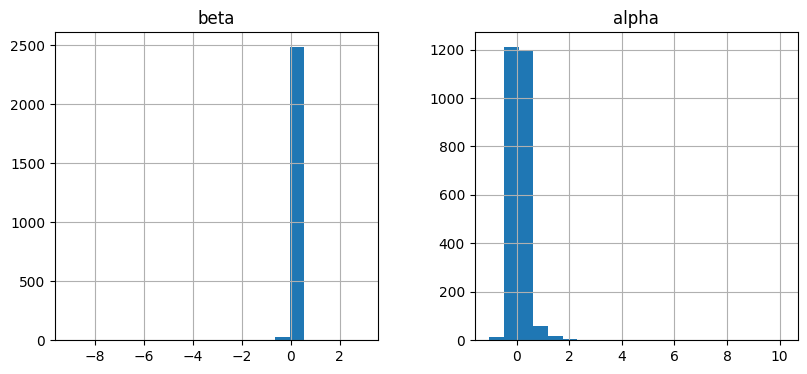

In [73]:
summary_df.hist(['beta', 'alpha'], bins=20, layout=(1,3), figsize=(15, 4))

## 5-Factor Alpha

In [74]:
# Calculate excess return
ff5_time_series['excess_return'] = ff5_time_series['irr'] - ff5_time_series['RF']

ff5_time_series.head()

,fund_id,irr,year,Mkt-RF,SMB,HML,RMW,CMA,RF,excess_return
0,2103,-0.285,1985-01-01,0.0184,-0.0065,-0.0026,0.0131,-0.0136,0.0064,-0.2914
1,2103,-0.285,1986-01-01,0.0388,-0.0041,-0.0154,0.0099,-0.0180,0.0065,-0.2915
2,2103,-0.285,1987-01-01,-0.0327,0.0012,0.0036,0.0079,0.0009,0.0049,-0.2899
3,2103,-0.285,1988-01-01,0.0681,0.0006,-0.0443,0.0296,-0.0242,0.0039,-0.2889
4,2103,-0.285,1989-01-01,0.0149,0.0201,-0.0169,0.0069,-0.0038,0.0063,-0.2913


In [75]:
ff5_time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29030 entries, 0 to 29029
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   fund_id        29030 non-null  int64         
 1   irr            29030 non-null  float64       
 2   year           29030 non-null  datetime64[ns]
 3   Mkt-RF         29030 non-null  float64       
 4   SMB            29030 non-null  float64       
 5   HML            29030 non-null  float64       
 6   RMW            29030 non-null  float64       
 7   CMA            29030 non-null  float64       
 8   RF             29030 non-null  float64       
 9   excess_return  29030 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 2.2 MB


In [76]:
# Function to run the regression for each fund and return important parameters
def run_ff5_regression(group):
    X = group[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]

    # Check for NaN values and handle them
    if X.isna().any().any() or group['excess_return'].isna().any():
        return pd.Series([None]*8, index=['alpha', 'beta_Mkt-RF', 'beta_SMB', 'beta_HML', 'beta_RMW', 'beta_CMA', 'R-squared', 'p-value_alpha'])

    X = sm.add_constant(X)
    Y = group['excess_return']

    model = sm.OLS(Y, X).fit()
    return pd.Series({
        'alpha': model.params.get('const', None),
        'beta_Mkt-RF': model.params.get('Mkt-RF', None),
        'beta_SMB': model.params.get('SMB', None),
        'beta_HML': model.params.get('HML', None),
        'beta_RMW': model.params.get('RMW', None),
        'beta_CMA': model.params.get('CMA', None),
        'R-squared': model.rsquared,
        'p-value_alpha': model.pvalues.get('const', None)
    })

# Group the data by fund and apply the regression function
ff5_regression_results = ff5_time_series.groupby('fund_id').apply(run_ff5_regression)

print(ff5_regression_results.head())

/Users/deniz/miniconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/deniz/miniconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/deniz/miniconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/deniz/miniconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/deniz/miniconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/deni

            alpha  beta_Mkt-RF  beta_SMB  beta_HML  beta_RMW  beta_CMA   
fund_id                                                                  
11       0.131479     0.021876  0.009267  0.009855  0.048632 -0.039809  \
30      -0.038891     0.000147  0.000790  0.052296 -0.003085 -0.072893   
31       0.212632    -0.005703 -0.007027  0.030005  0.002676 -0.052922   
32       0.104473     0.031101  0.018305 -0.012841  0.072863 -0.016549   
33      -0.007906     0.025488  0.004857  0.006434 -0.007191 -0.058125   

         R-squared  p-value_alpha  
fund_id                            
11        0.386607   8.938394e-18  
30        0.299245   1.116994e-12  
31        0.262967   9.846627e-20  
32        0.476133   5.813379e-17  
33        0.314560   2.983915e-06  


In [77]:
ff5_regression_results.describe()

,alpha,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA,R-squared,p-value_alpha
count,2512.000000,2521.000000,2521.000000,2521.000000,2521.000000,2521.000000,2519.000000,1.964000e+03
mean,0.172647,0.029170,0.006112,-0.004264,0.034777,-0.000254,-inf,3.690352e-03
std,0.382136,0.370515,0.327975,0.137131,0.227780,0.515080,NaN,3.832805e-02
min,-1.002330,-1.263674,-15.710837,-1.262646,-0.882187,-2.014725,-inf,1.091247e-39
25%,0.024301,0.009216,0.001327,-0.016593,0.002125,-0.037024,0.211124,1.000846e-19
50%,0.121922,0.011442,0.010583,-0.005817,0.020040,-0.007180,0.387826,6.578516e-15
75%,0.246863,0.023969,0.017567,0.009855,0.050818,0.010957,0.993922,1.271050e-08
max,10.154862,15.564007,3.385530,6.107916,10.865439,24.814313,1.000000,8.534488e-01


## Exploratory Data Analysis

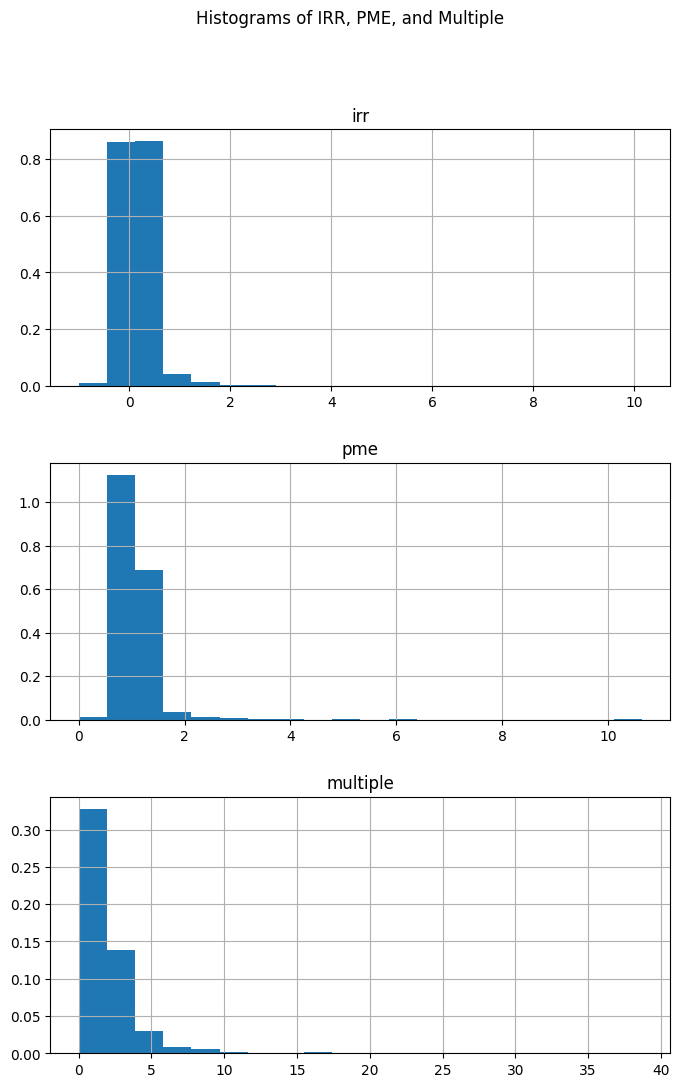

In [88]:
# Histograms for IRR, PME, and Multiple
vc_returns[['irr', 'pme', 'multiple']].hist(bins=20, figsize=(8, 12), layout=(3,1), density=True)
plt.suptitle('Histograms of IRR, PME, and Multiple')
plt.show()

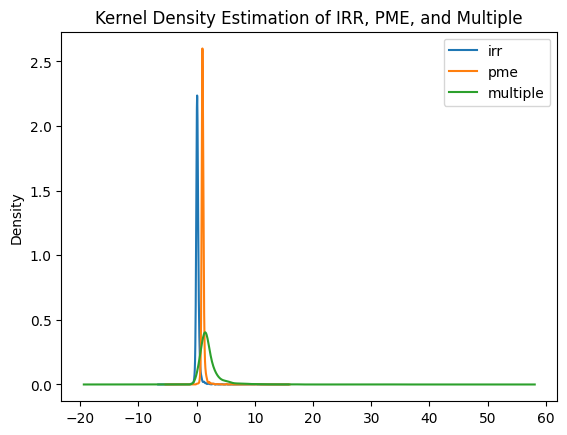

In [79]:
# Plot KDE
vc_returns[['irr', 'pme', 'multiple']].plot.kde()
plt.title('Kernel Density Estimation of IRR, PME, and Multiple')
plt.show()

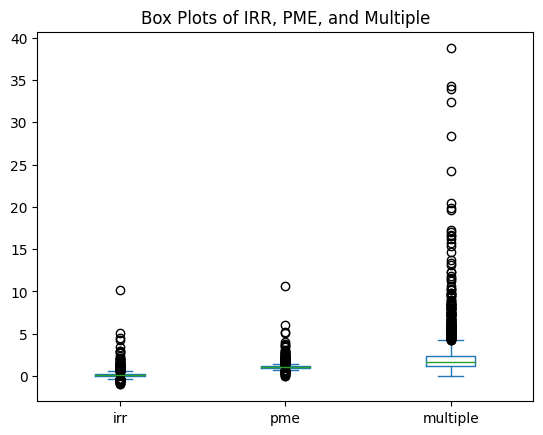

In [80]:
# Plot box plots
vc_returns[['irr', 'pme', 'multiple']].plot.box()
plt.title('Box Plots of IRR, PME, and Multiple')
plt.show()

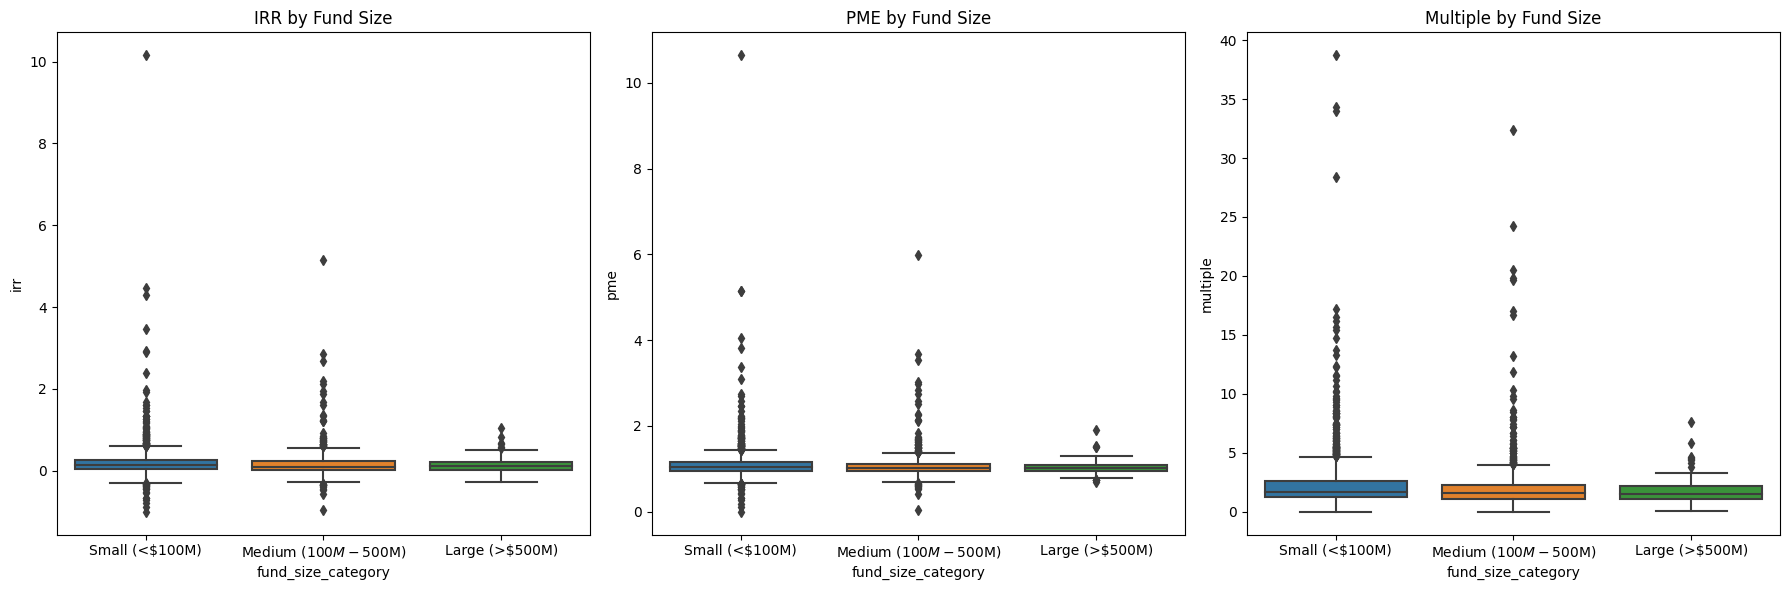

In [81]:
# Define fund size categories
bins = [0, 100, 500, np.inf]
names = ['Small (<$100M)', 'Medium ($100M-$500M)', 'Large (>$500M)']

vc_returns['fund_size_category'] = pd.cut(vc_returns['fund_size'], bins, labels=names)

# Plotting performance metrics by fund size
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='fund_size_category', y='irr', data=vc_returns, ax=ax[0])
ax[0].set_title('IRR by Fund Size')

sns.boxplot(x='fund_size_category', y='pme', data=vc_returns, ax=ax[1])
ax[1].set_title('PME by Fund Size')

sns.boxplot(x='fund_size_category', y='multiple', data=vc_returns, ax=ax[2])
ax[2].set_title('Multiple by Fund Size')

plt.tight_layout()
plt.show()

In [89]:
# Average performance metrics by fund size
avg_perf_by_size = vc_returns.groupby('fund_size_category')[['irr', 'pme', 'multiple']].mean()
avg_perf_by_size

,irr,pme,multiple
fund_size_category,,,
Small (<$100M),0.198538,1.095380,2.340770
Medium ($100M-$500M),0.150221,1.065084,2.013581
Large (>$500M),0.118113,1.032054,1.715355


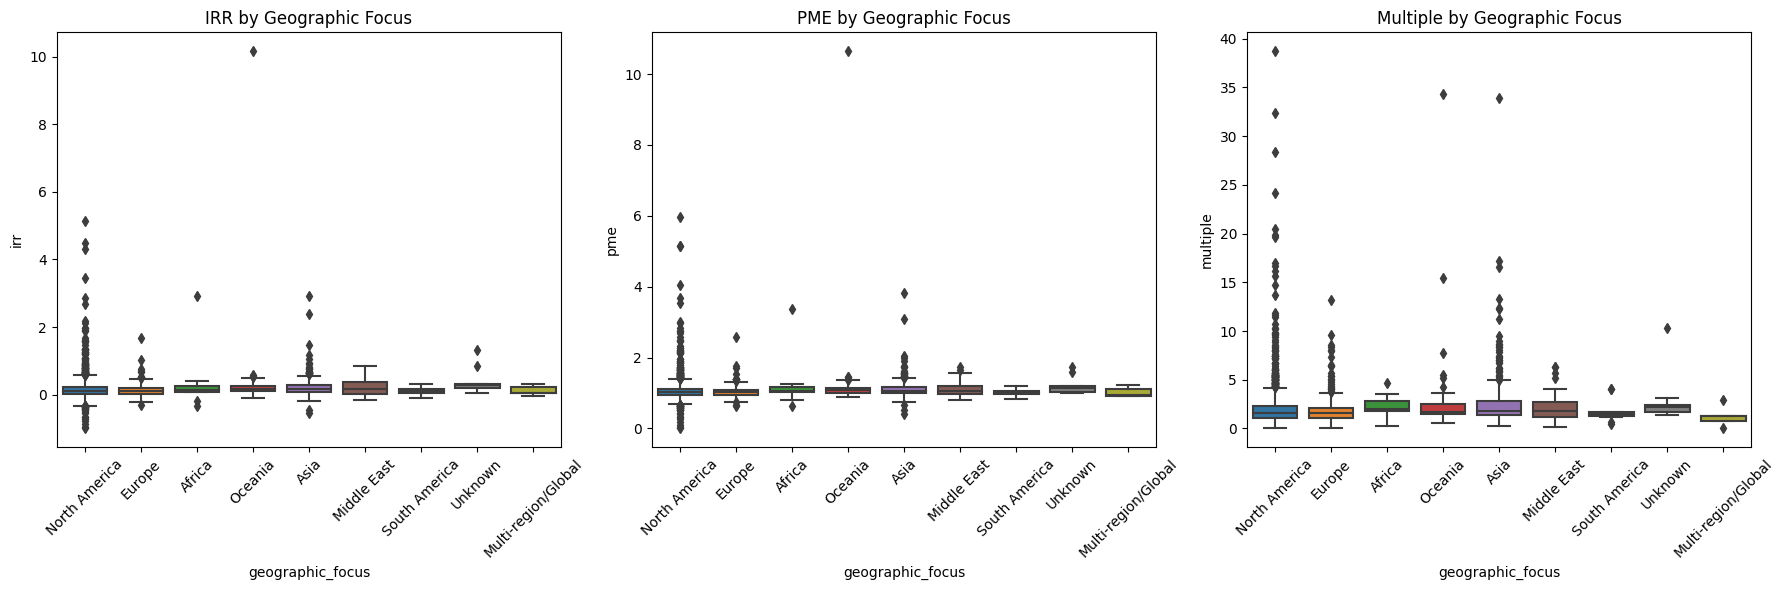

In [83]:
# Plot performance metrics by geographic focus
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='geographic_focus', y='irr', data=vc_returns, ax=ax[0])
ax[0].set_title('IRR by Geographic Focus')
ax[0].tick_params(axis='x', rotation=45)

sns.boxplot(x='geographic_focus', y='pme', data=vc_returns, ax=ax[1])
ax[1].set_title('PME by Geographic Focus')
ax[1].tick_params(axis='x', rotation=45)

sns.boxplot(x='geographic_focus', y='multiple', data=vc_returns, ax=ax[2])
ax[2].set_title('Multiple by Geographic Focus')
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [96]:
# Distribution of metrics by geographic focus
# Initialize a dictionary to store the distributions
distributions = {}

for metric in ['irr', 'pme', 'multiple']:
    dist_by_geo_focus = vc_returns.groupby('geographic_focus')[metric].describe()
    
    # Rename the columns to include the metric name
    dist_by_geo_focus.columns = [f"{metric}_{col}" for col in dist_by_geo_focus.columns]
    
    # Store the distribution in the dictionary
    distributions[metric] = dist_by_geo_focus

# Display irr table
distributions['irr']

,irr_count,irr_mean,irr_std,irr_min,irr_25%,irr_50%,irr_75%,irr_max
geographic_focus,,,,,,,,
Africa,18.0,0.282372,0.678423,-0.3300,0.079000,0.13250,0.262250,2.910000
Asia,350.0,0.231125,0.279480,-0.5300,0.087500,0.17890,0.290900,2.930000
Europe,318.0,0.122175,0.183296,-0.3004,0.026200,0.09950,0.209250,1.685000
Middle East,58.0,0.208014,0.244451,-0.1490,0.021375,0.16650,0.372529,0.841000
Multi-region/Global,5.0,0.121726,0.151288,-0.0500,0.049000,0.06000,0.219628,0.330000
North America,1700.0,0.162952,0.353468,-1.0000,0.011000,0.11100,0.239250,5.143300
Oceania,40.0,0.449168,1.581955,-0.0902,0.099750,0.17410,0.269000,10.157100
South America,11.0,0.119755,0.125411,-0.1080,0.056400,0.11000,0.171500,0.320000
Unknown,12.0,0.362702,0.367813,0.0640,0.185750,0.27715,0.305500,1.334914


In [97]:
# Display pme by geographic focus
distributions['pme']

,pme_count,pme_mean,pme_std,pme_min,pme_25%,pme_50%,pme_75%,pme_max
geographic_focus,,,,,,,,
Africa,18.0,1.186138,0.566391,0.639859,1.022657,1.069890,1.176763,3.371978
Asia,350.0,1.116786,0.258380,0.414804,0.992353,1.065903,1.165626,3.823391
Europe,318.0,1.037104,0.164476,0.639217,0.953696,1.023711,1.095164,2.585381
Middle East,58.0,1.108318,0.212095,0.796335,0.963431,1.049031,1.210185,1.747660
Multi-region/Global,5.0,1.021140,0.137179,0.904656,0.920803,0.949549,1.115744,1.214947
North America,1700.0,1.071009,0.329485,0.000000,0.941028,1.022419,1.127998,5.976651
Oceania,40.0,1.339248,1.515584,0.881839,1.007245,1.074799,1.147289,10.644724
South America,11.0,1.021094,0.097894,0.839750,0.971483,0.996349,1.071457,1.190768
Unknown,12.0,1.190519,0.233358,0.993400,1.038008,1.134602,1.187163,1.736252


In [98]:
# Display multiple by geographic focus
distributions['multiple']

,multiple_count,multiple_mean,multiple_std,multiple_min,multiple_25%,multiple_50%,multiple_75%,multiple_max
geographic_focus,,,,,,,,
Africa,18.0,2.270454,1.040963,0.279371,1.778150,2.050000,2.857500,4.640000
Asia,350.0,2.662845,2.763620,0.210000,1.426400,1.795500,2.829225,33.958333
Europe,318.0,1.917633,1.520370,0.039333,1.122500,1.615150,2.117500,13.180000
Middle East,58.0,2.093671,1.432686,0.183890,1.132984,1.745609,2.715250,6.330000
Multi-region/Global,5.0,1.242326,1.058893,0.018900,0.800000,1.239300,1.240000,2.913428
North America,1700.0,2.093027,2.342743,0.000000,1.076025,1.638206,2.339250,38.724800
Oceania,40.0,3.339106,5.618284,0.593200,1.498651,1.690500,2.559000,34.330000
South America,11.0,1.780391,1.188946,0.459700,1.255350,1.503000,1.652250,4.092000
Unknown,12.0,2.767509,2.405110,1.427553,1.739550,2.177150,2.398476,10.267900


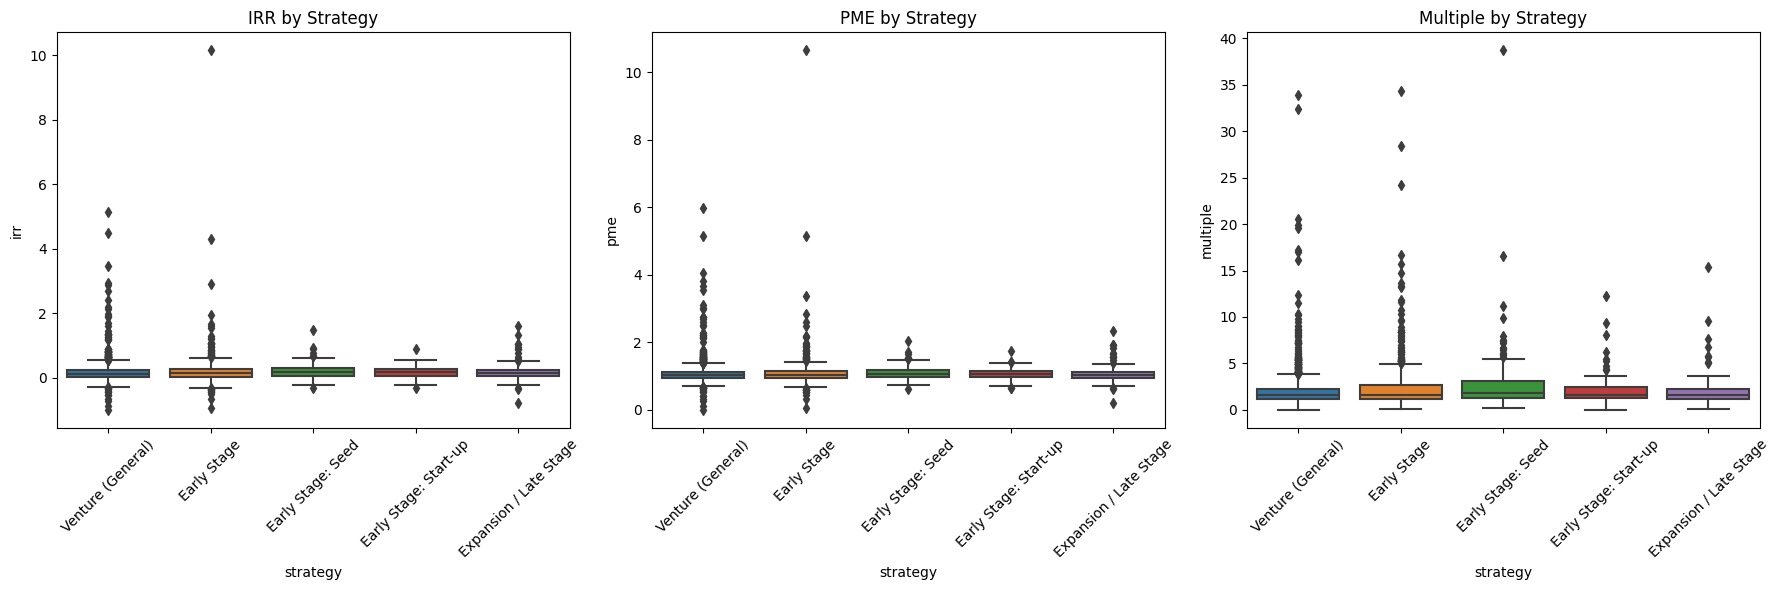

In [463]:
# Plot performance metrics by strategy
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='strategy', y='irr', data=vc_returns, ax=ax[0])
ax[0].set_title('IRR by Strategy')
ax[0].tick_params(axis='x', rotation=45)

sns.boxplot(x='strategy', y='pme', data=vc_returns, ax=ax[1])
ax[1].set_title('PME by Strategy')
ax[1].tick_params(axis='x', rotation=45)

sns.boxplot(x='strategy', y='multiple', data=vc_returns, ax=ax[2])
ax[2].set_title('Multiple by Strategy')
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [99]:
# Average metrics by strategy
avg_perf_by_strategy = vc_returns.groupby('strategy')[['irr', 'pme', 'multiple']].mean()
avg_perf_by_strategy

,irr,pme,multiple
strategy,,,
Early Stage,0.189887,1.093123,2.353036
Early Stage: Seed,0.198843,1.079556,2.745115
Early Stage: Start-up,0.164754,1.054867,2.094999
Expansion / Late Stage,0.166753,1.063658,1.958136
Venture (General),0.164990,1.076603,2.036463


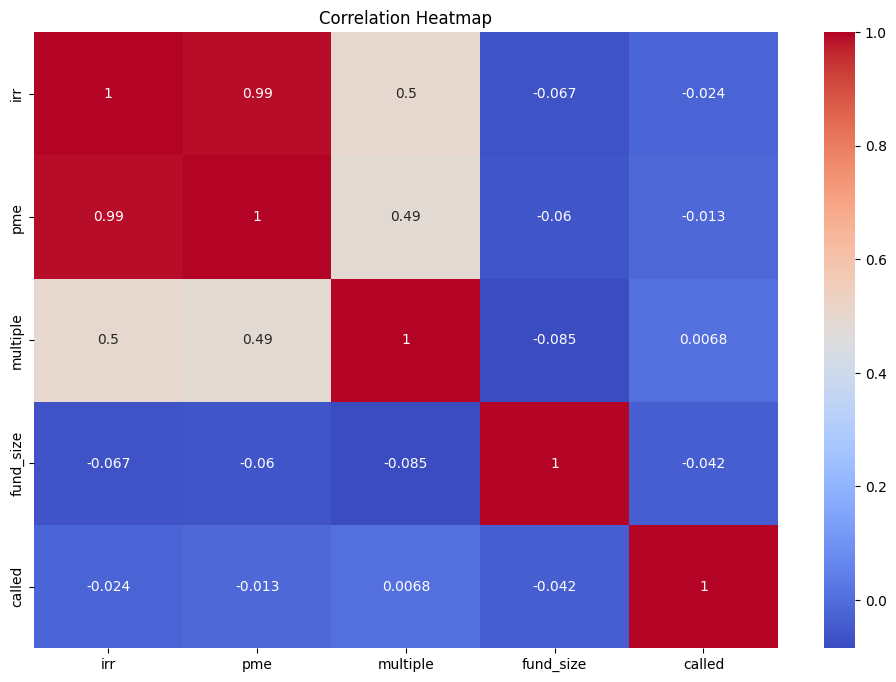

In [464]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(vc_returns[['irr', 'pme', 'multiple', 'fund_size', 'called']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

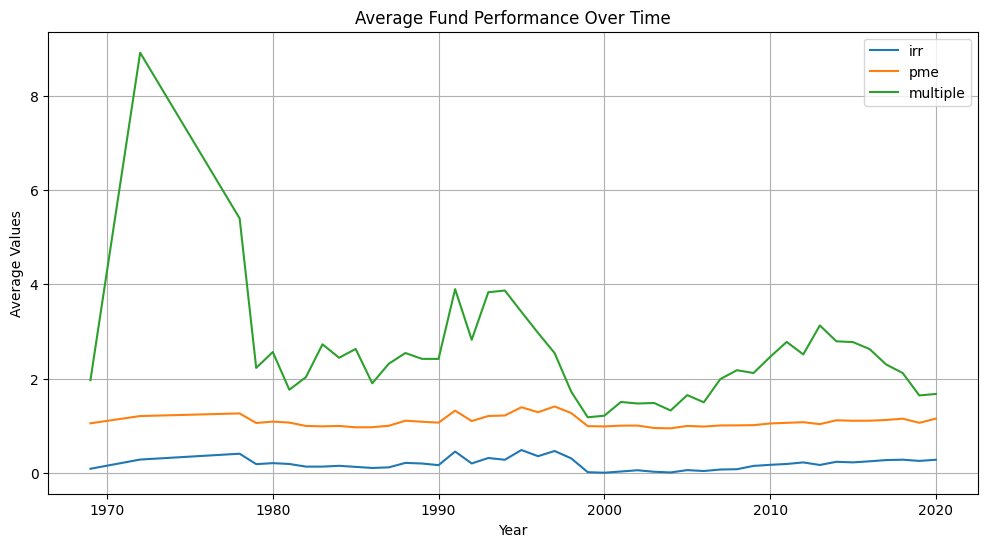

In [468]:
# Calculate yearly averages
yearly_averages = vc_returns.groupby(vc_returns['vintage'].dt.year)[['irr', 'pme', 'multiple']].mean()

# Plotting
yearly_averages.plot(figsize=(12, 6))
plt.title('Average Fund Performance Over Time')
plt.ylabel('Average Values')
plt.xlabel('Year')
plt.grid(True)
plt.show()
